In [1]:
import os
import sys
from pyspark import SparkContext
from pyspark import SparkConf
#import findspark
from pyspark.sql import SQLContext
from pyspark.sql import HiveContext
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.cm as cm


#import matplotlib
#matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

#findspark.init()

try:
    sc = SparkContext("local", "test")
except:
    print("SparkContext exists already")
print(sc)




In [2]:
sqlContext = SQLContext(sc)
hiveContext = HiveContext(sc)
#test = spark.sql("show tables")
sqlContext.sql("use default")
#hiveContext.sql("use default")
sqlContext.sql("show tables").show()



+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
+--------+---------+-----------+



In [3]:
# there is a bug, I have to call this cell twice
sqlContext = SQLContext(sc)
hiveContext = HiveContext(sc)
#test = spark.sql("show tables")
sqlContext.sql("use default")
#hiveContext.sql("use default")
sqlContext.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|     all_states_2006|      false|
| default|all_states_2006_c...|      false|
| default|     all_states_2007|      false|
| default|all_states_2007_c...|      false|
| default|     all_states_2008|      false|
| default|all_states_2008_c...|      false|
| default|     all_states_2009|      false|
| default|all_states_2009_c...|      false|
| default|     all_states_2010|      false|
| default|all_states_2010_c...|      false|
| default|     all_states_2011|      false|
| default|all_states_2011_c...|      false|
| default|     all_states_2012|      false|
| default|all_states_2012_c...|      false|
| default|     all_states_2013|      false|
| default|all_states_2013_c...|      false|
| default|     all_states_2014|      false|
| default|all_states_2014_c...|      false|
| default|     all_states_2015|      false|
| default|all_states_2015_c...| 

In [4]:
df = sqlContext.table("default.merged_storm_econ_data")

In [5]:
df.printSchema()

root
 |-- quarter: string (nullable = true)
 |-- year: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_fips: string (nullable = true)
 |-- storm_events: long (nullable = true)
 |-- direct_injuries: double (nullable = true)
 |-- indirect_injuries: double (nullable = true)
 |-- direct_deaths: double (nullable = true)
 |-- indirect_deaths: double (nullable = true)
 |-- property_damage: double (nullable = true)
 |-- crop_damage: double (nullable = true)
 |-- quarterly_contributions: string (nullable = true)
 |-- quarterly_wages: string (nullable = true)
 |-- quarterly_wage_changes: string (nullable = true)
 |-- quarterly_change_percentage: string (nullable = true)



## Data Cleanup

In [6]:
w = Window().partitionBy().orderBy('year','quarter','state')
pdf = df.select('*',(lag("storm_events",200).over(w).alias("storm_events_last_year"))).toPandas()
pdf['storm_events_change_percentage'] = \
                ((pdf['storm_events'] / pdf['storm_events_last_year'])-1)*100
pdf['quarterly_wages'] = pdf['quarterly_wages'].astype(float)
pdf['quarterly_wage_changes'] = pdf['quarterly_wage_changes'].astype(float)
pdf['quarterly_change_percentage'] = pdf['quarterly_change_percentage'].astype(float)
pdf.head(10)

,quarter,year,state,state_fips,storm_events,direct_injuries,indirect_injuries,direct_deaths,indirect_deaths,property_damage,crop_damage,quarterly_contributions,quarterly_wages,quarterly_wage_changes,quarterly_change_percentage,storm_events_last_year,storm_events_change_percentage
0,1,2006,ALABAMA,1,124,5.0,0.0,1.0,0.0,0.0,0.0,129627325,1.379901e+10,1.362283e+09,11.0,NaN,NaN
1,1,2006,ALASKA,2,141,2.0,0.0,2.0,0.0,0.0,0.0,53723488,2.161476e+09,2.082567e+08,10.7,NaN,NaN
2,1,2006,ARIZONA,4,51,13.0,0.0,10.0,0.0,0.0,0.0,166784066,2.176490e+10,3.247063e+09,17.5,NaN,NaN
3,1,2006,ARKANSAS,5,321,18.0,0.0,1.0,0.0,0.0,0.0,132071103,7.698681e+09,7.044469e+08,10.1,NaN,NaN
4,1,2006,CALIFORNIA,6,347,46.0,0.0,11.0,0.0,0.0,0.0,2845405417,1.574490e+11,1.783388e+10,12.8,NaN,NaN
5,1,2006,COLORADO,8,339,2.0,0.0,2.0,0.0,0.0,0.0,266510319,2.081841e+10,2.428879e+09,13.2,NaN,NaN
6,1,2006,CONNECTICUT,9,60,0.0,0.0,0.0,0.0,0.0,0.0,285816963,2.239856e+10,2.284873e+09,11.4,NaN,NaN
7,1,2006,DELAWARE,10,48,0.0,0.0,0.0,0.0,0.0,0.0,50110784,4.505171e+09,4.519578e+08,11.2,NaN,NaN
8,1,2006,FLORIDA,12,86,21.0,0.0,2.0,0.0,0.0,0.0,694117598,6.493007e+10,7.474070e+09,13.0,NaN,NaN
9,1,2006,GEORGIA,13,206,5.0,0.0,0.0,0.0,0.0,0.0,357777176,3.500534e+10,3.450826e+09,10.9,NaN,NaN


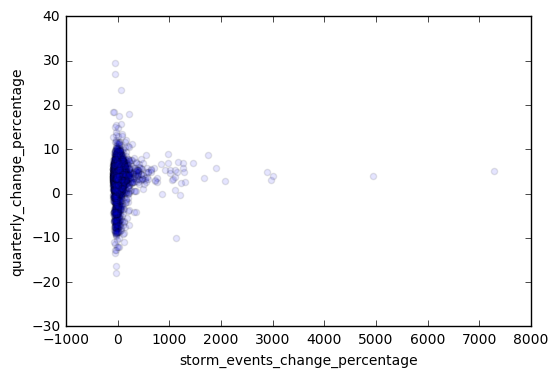

In [7]:
fig = plt.figure(figsize = (16,8))
pdf.plot.scatter(x='storm_events_change_percentage', y='quarterly_change_percentage', alpha = 0.1)
plt.show()

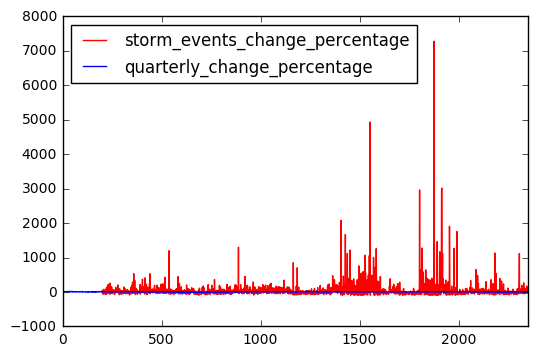

In [8]:
fig = plt.figure(figsize = (16,16))
ax = pdf.plot(y='storm_events_change_percentage', color='r')
pdf.plot(y='quarterly_change_percentage', color='b', ax=ax)
plt.show()

In [9]:
from sklearn import linear_model

pdf1 = pdf.loc[200:,['storm_events_change_percentage','quarterly_change_percentage']]
pdf2 = np.array(pdf1)





In [10]:
pdf_national = pdf.groupby(['year','quarter'],as_index=False).sum()[['quarterly_wages','quarterly_wage_changes']]
#pdf_national['national_quarterly_wage_changes_percentage'] = (pdf_national['quarterly_wage_changes']/pdf_national['quarterly_wages'])*100
national_pct = np.array((pdf_national['quarterly_wage_changes']/pdf_national['quarterly_wages'])*100)
national_pct.shape

(43,)

In [11]:
np_state = np.array(pdf[['year','quarter','state','storm_events_change_percentage','quarterly_change_percentage']])
np_state = np_state[200:,]
rows = np_state.shape[0]
national_pct_tile = np.repeat(national_pct,50).reshape(rows,1)
np_state = np.hstack([np_state,national_pct_tile])
np_state[:20,]
np_state.shape

(2150, 6)

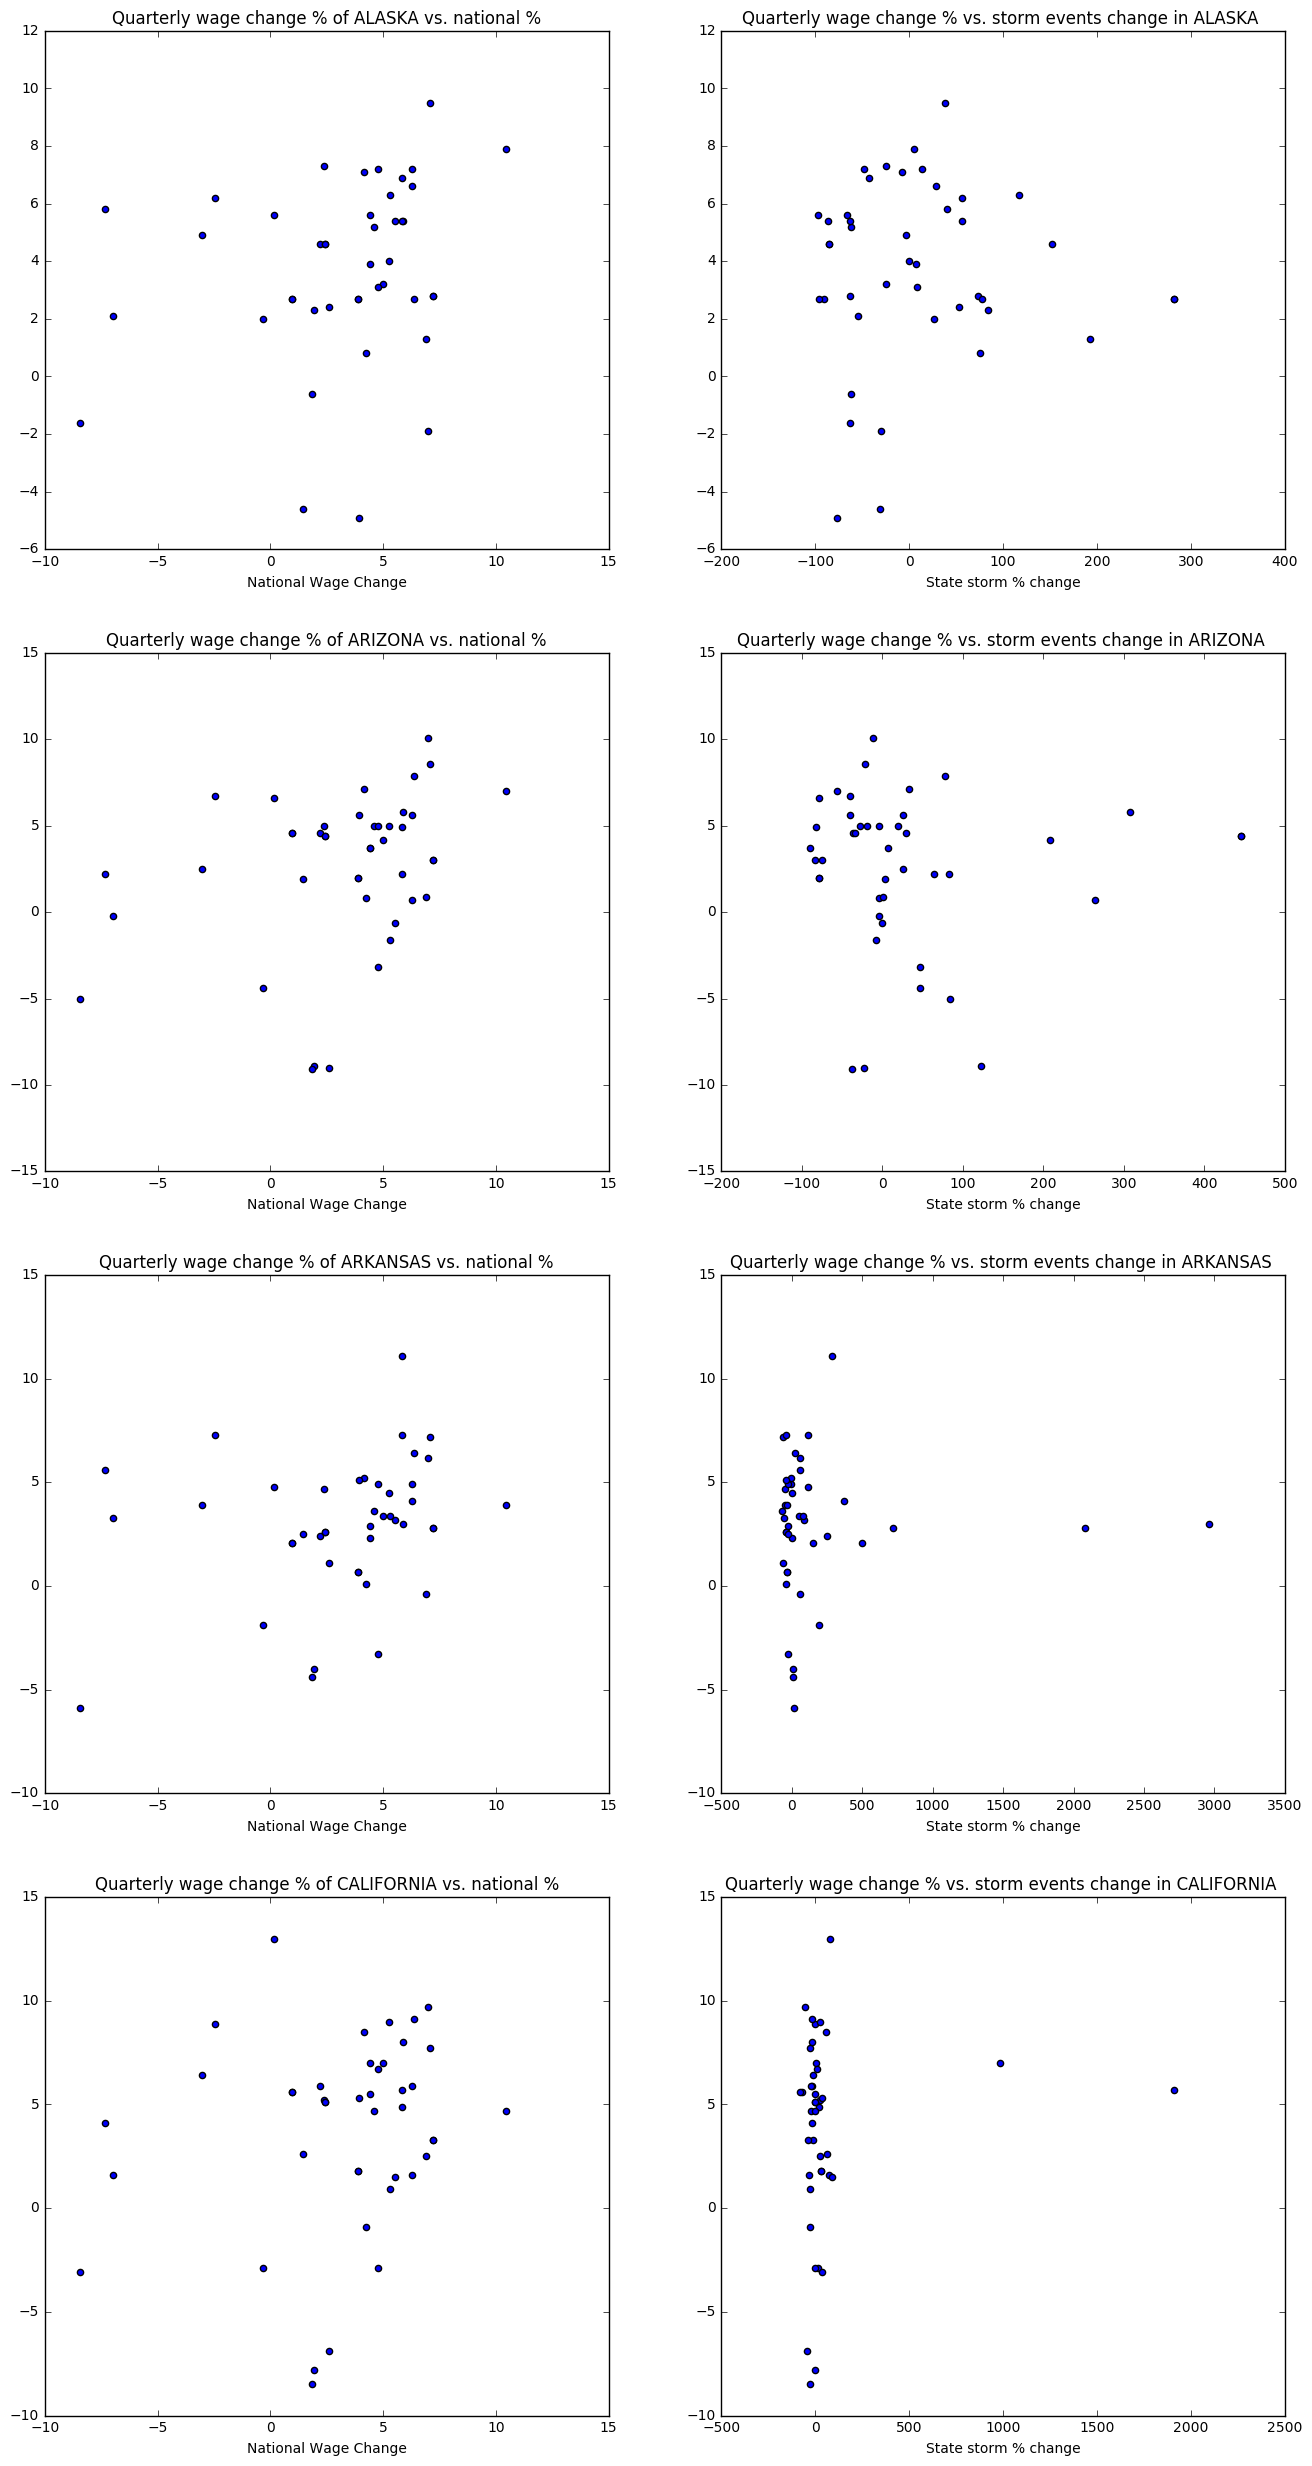

In [12]:

states = pdf.state.unique()


i = 0
plt.figure(figsize = (16,400))
for state in states[1:5]:
    nps = np_state[np_state[:,2] == state]
    p = plt.subplot(states.shape[0], 2, i+1)
    # 5 is national, #4 is regional % wage change
    p.scatter(x=nps[:,5], y=nps[:,4])
    title_text1 = "Quarterly wage change % of {0:s} vs. national %".format(state)
    plt.title(title_text1)
    plt.xlabel("National Wage Change")
    p = plt.subplot(states.shape[0], 2, i+2)
    # 3 is regional storm % change, #4 is regional % wage change
    p.scatter(x=nps[:,3], y=nps[:,4])
    title_text2 = "Quarterly wage change % vs. storm events change in {0:s} ".format(state)
    plt.title(title_text2)
    plt.xlabel("State storm % change")
    i += 2
    
plt.show()
                
                    



### Linear (OLS) model
$regional\_wage\_change = \beta_0 + \beta_1*regional\_storm\_event\_change  + \beta_2*national\_wage\_change$

In [13]:
reg = linear_model.LinearRegression(normalize=True)
np_regression = np.empty((50,2))
ind = 0;
for state in states:
    nps = np_state[np_state[:,2] == state]
    # 3 is regional storm % change, 4 is regional % wage, change 5 is national % wage change,
    reg.fit(nps[:,[3,5]],nps[:,4])
    #print(reg.get_params())
    print(reg.coef_)
    np_regression[ind] = reg.coef_
    ind += 1
#print(np_regression)




[ 0.00286102  0.23098353]
[-0.00023661  0.17530449]
[ 0.00038489  0.36508645]
[ -1.74957982e-04   2.26216546e-01]
[ 0.00132235  0.21248233]
[ 0.00322886  0.3750185 ]
[ 0.00314427  0.06519713]
[ 0.00224123  0.06603913]
[ 0.0037563   0.28034296]
[ 0.0021269   0.25712661]
[-0.01828406  0.3963273 ]
[ 0.00260166  0.33437948]
[ 0.00490339  0.21903953]
[ 0.00402337  0.10211622]
[ 0.00058889  0.22841174]
[ 0.00036985  0.33628224]
[ 0.00070005  0.25477597]
[-0.00561306  0.3070136 ]
[ 0.00275299  0.20590445]
[ 0.00043939  0.1770589 ]
[ 0.01827085  0.22939994]
[ 0.01734385  0.25524562]
[ 0.00576112  0.19141363]
[ 0.00975953  0.26498661]
[ 0.00337256  0.38102711]
[ -7.40729381e-05   4.00408418e-01]
[  9.78735090e-05   3.35835212e-01]
[ 0.00817859  0.70077571]
[ 0.01552758  0.29937619]
[ 0.01257735  0.22237188]
[-0.00345325  0.35610714]
[ 0.02419218  0.05906573]
[ 0.01098819  0.26251795]
[-0.01362668  0.06368287]
[ 0.00580795  0.23464121]
[ 0.0016776   0.31199576]
[ 0.0115577   0.39989327]
[ 0.0103

In [14]:
pdf1 = np.column_stack((states,np_regression))
pdf1 = pd.DataFrame(data = pdf1, columns=['State', 'Beta_storm','Beta_national'])


In [15]:
sdf = sqlContext.createDataFrame(pdf1)
sdf.registerTempTable("mytempTable") 
sqlContext.sql("CREATE TABLE regression_data AS SELECT * FROM mytempTable")
sqlContext.dropTempTable("mytempTable")

In [16]:
pdf1.head(50)


,State,Beta_storm,Beta_national
0,ALABAMA,0.00286102,0.230984
1,ALASKA,-0.000236609,0.175304
2,ARIZONA,0.000384893,0.365086
3,ARKANSAS,-0.000174958,0.226217
4,CALIFORNIA,0.00132235,0.212482
5,COLORADO,0.00322886,0.375019
6,CONNECTICUT,0.00314427,0.0651971
7,DELAWARE,0.00224123,0.0660391
8,FLORIDA,0.0037563,0.280343
9,GEORGIA,0.0021269,0.257127
